## BYM-OU (Time-Based) Model Analysis

This notebook analyzes the results from the temporal BYM-OU model (`run_model.py --model bym_ou`). It loads the latest results from `./Res/bym_ou_*`, computes posterior summaries, and visualizes key temporal quantities, including patient predictions over time and the evolution of `Lambda`.


In [1]:
# Enable inline display and ensure plots directory exists
import os as _os
import matplotlib.pyplot as _plt

try:
    _plt.ion()
except Exception:
    pass
PLOTS_DIR = 'plots'
_os.makedirs(PLOTS_DIR, exist_ok=True)


In [2]:
import os
import re
import glob
import json
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib_inline.backend_inline import set_matplotlib_formats
from datetime import datetime
from dataloader import load_data

# Display settings
sns.set(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
set_matplotlib_formats('png')
mpl.rcParams['figure.dpi'] = 72
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = False

RES_DIR = './Res'


In [ ]:
# Load the latest BYM-OU model results
def latest_bym_ou_dir(res_dir=RES_DIR):
    bym_ou_dirs = sorted(glob.glob(os.path.join(res_dir, 'bym_ou_*')))
    if not bym_ou_dirs:
        raise FileNotFoundError('No BYM-OU results found in ./Res (expected directories matching bym_ou_*)')
    return bym_ou_dirs[-1]

bym_ou_dir = latest_bym_ou_dir()
samples_path = os.path.join(bym_ou_dir, 'mcmc_samples.npy')
if not os.path.exists(samples_path):
    raise FileNotFoundError(f'mcmc_samples.npy not found in {bym_ou_dir}')

print(f"Loading samples from: {samples_path}")
samples_obj = np.load(samples_path, allow_pickle=True).item()

# Extract static samples
delta_samples = np.asarray(samples_obj.get('delta'))
tau_s_samples = np.asarray(samples_obj.get('tau_s'))
tau_u_samples = np.asarray(samples_obj.get('tau_u'))
rho_ou_samples = np.asarray(samples_obj.get('rho_ou'))
sigma_ou_samples = np.asarray(samples_obj.get('sigma_ou'))
delta_corr_samples = np.asarray(samples_obj.get('delta_corr'))

# Extract and stack time-varying samples (Lambda_t and phi_t)
lambda_samples_t = []
phi_samples_t = []
t_keys_lambda = sorted([k for k in samples_obj.keys() if k.startswith('Lambda_')], key=lambda x: int(x.split('_')[1]))
t_keys_phi = sorted([k for k in samples_obj.keys() if k.startswith('phi_')], key=lambda x: int(x.split('_')[1]))

for k in t_keys_lambda:
    lambda_samples_t.append(np.asarray(samples_obj[k]))

for k in t_keys_phi:
    phi_samples_t.append(np.asarray(samples_obj[k]))

# Stack into single arrays with time as a new dimension
# Shape: (num_samples, T, I, C) for Lambda, (num_samples, T, I) for phi
if lambda_samples_t:
    lambda_samples = np.stack(lambda_samples_t, axis=1)
else:
    lambda_samples = np.array([])
    
if phi_samples_t:
    phi_samples = np.stack(phi_samples_t, axis=1)
else:
    phi_samples = np.array([])


print('delta_samples:', delta_samples.shape)
print('tau_s_samples:', tau_s_samples.shape)
print('tau_u_samples:', tau_u_samples.shape)
print('rho_ou_samples:', rho_ou_samples.shape)
print('sigma_ou_samples:', sigma_ou_samples.shape)
print('delta_corr_samples:', delta_corr_samples.shape)
print('lambda_samples (stacked):', lambda_samples.shape)
print('phi_samples (stacked):', phi_samples.shape)

# Load data to get condition list for labels
_, _, condition_list = load_data()
condition_names = [c.name for c in condition_list]
# Align condition_names length with inferred C
try:
    if lambda_samples.size > 0:
        C_inferred = int(lambda_samples.shape[3])
    elif delta_samples is not None and delta_samples.size > 0:
        C_inferred = int(delta_samples.shape[1])
    else:
        C_inferred = len(condition_names)
    condition_names = condition_names[:C_inferred]
except Exception:
    pass



Loading samples from: ./Res/bym_ou_20251022_150951/mcmc_samples.npy
delta_samples: (4000, 43)
tau_s_samples: (4000,)
tau_u_samples: (4000,)
rho_ou_samples: (4000,)
sigma_ou_samples: (4000,)
delta_corr_samples: (4000, 43, 43)
lambda_samples (stacked): (4000, 10, 100, 43)
phi_samples (stacked): (4000, 10, 100)


### 1. Patient Predictions Over Time

This section analyzes the posterior predictive probabilities for patients across different time steps. We compute the mean probabilities from the `Lambda` samples and visualize how they evolve.


In [ ]:
# Compute posterior mean probabilities over time

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Normalize arrays to (T, I, C)
def _to_TIC(arr, expected_T=None):
    """Ensure array has shape (T, I, C). If needed, transpose based on expected T."""
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array for time x patient x condition; got shape {arr.shape}")
    T0, I0, C0 = arr.shape
    if expected_T is None or T0 == expected_T:
        return arr  # (T, I, C)
    # Try other common layouts
    if C0 == expected_T:  # (I, C, T)
        return np.transpose(arr, (2, 0, 1))
    if I0 == expected_T:  # (C, T, I)
        return np.transpose(arr, (1, 2, 0))
    # Fallback: return as-is
    return arr

if lambda_samples.size > 0:
    # Get shape info
    S, T_s, I_s, C_s = lambda_samples.shape

    # Compute mean over samples
    lambda_mean_any = lambda_samples.mean(axis=0)  # any layout of (T, I, C)

    # Use number of Lambda_t keys as expected T if available
    try:
        expected_T = len(t_keys_lambda) if isinstance(t_keys_lambda, list) and len(t_keys_lambda) > 0 else None
    except NameError:
        expected_T = None

    # Normalize to (T, I, C)
    lambda_mean_t = _to_TIC(lambda_mean_any, expected_T=expected_T)

    # Convert to probabilities
    prob_mean_t = sigmoid(lambda_mean_t)  # Shape: (T, I, C)

    T, I, C = prob_mean_t.shape
    print(f"Computed mean probabilities over {T} time steps for {I} patients and {C} conditions.")
else:
    print("No Lambda samples found to compute probabilities.")
    prob_mean_t = np.array([])



Computed mean probabilities over 10 time steps for 100 patients and 43 conditions.


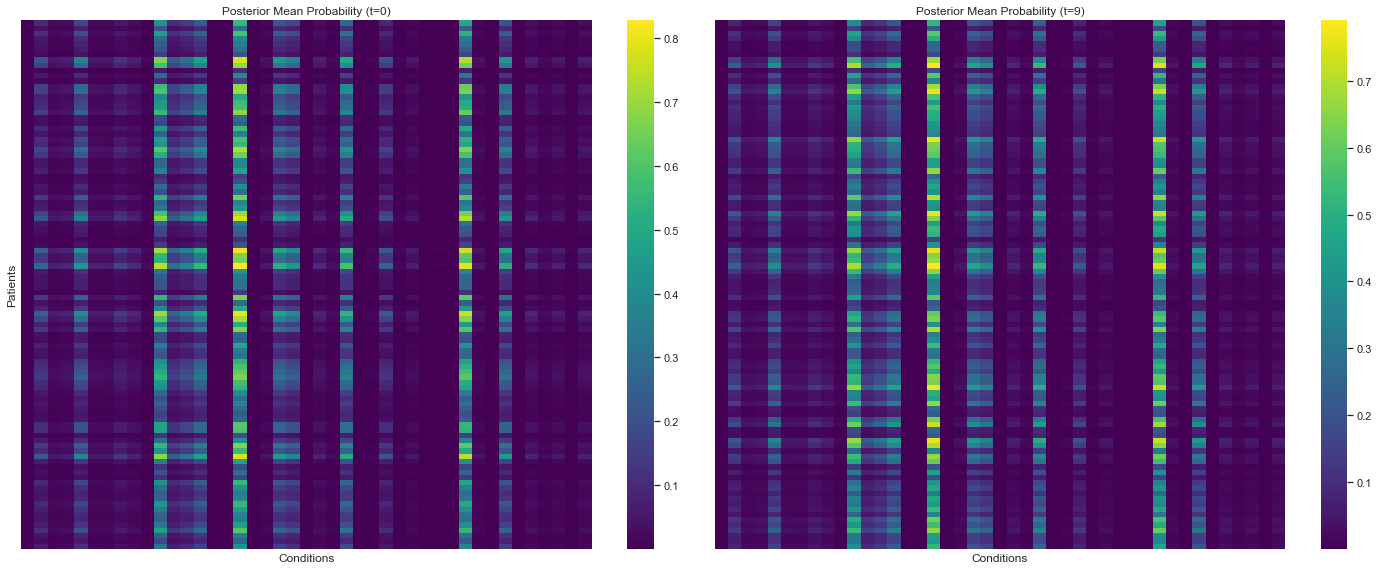

In [5]:
# Heatmap of posterior mean probabilities at first and last time step
if prob_mean_t.size > 0:
    T = prob_mean_t.shape[0]
    
    # Get probabilities at t=0 and t=T-1
    prob_mean_t0 = prob_mean_t[0, :, :]
    prob_mean_t_final = prob_mean_t[-1, :, :]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Heatmap at t=0
    sns.heatmap(prob_mean_t0, cmap='viridis', xticklabels=False, yticklabels=False, cbar=True, ax=axes[0])
    axes[0].set_title('Posterior Mean Probability (t=0)')
    axes[0].set_xlabel('Conditions')
    axes[0].set_ylabel('Patients')
    
    # Heatmap at t=T-1
    sns.heatmap(prob_mean_t_final, cmap='viridis', xticklabels=False, yticklabels=False, cbar=True, ax=axes[1])
    axes[1].set_title(f'Posterior Mean Probability (t={T-1})')
    axes[1].set_xlabel('Conditions')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'bym_ou_prob_mean_heatmap_t0_vs_t_final.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("Skipping heatmap visualization as no probability data is available.")



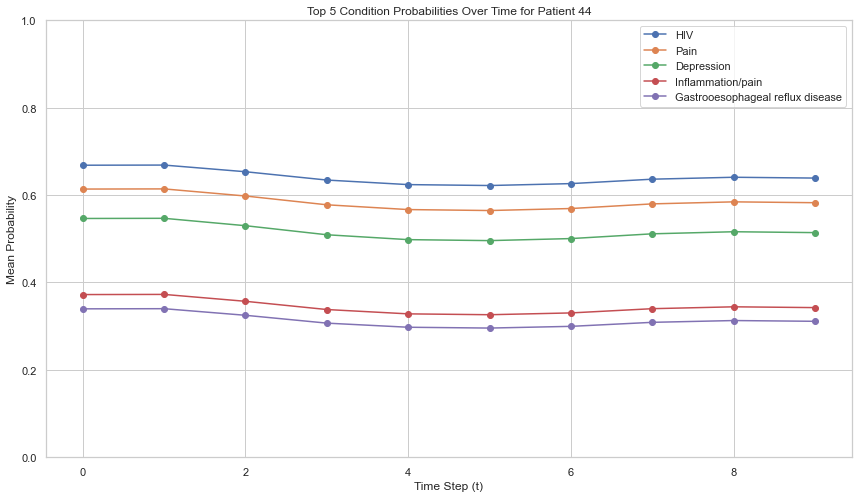

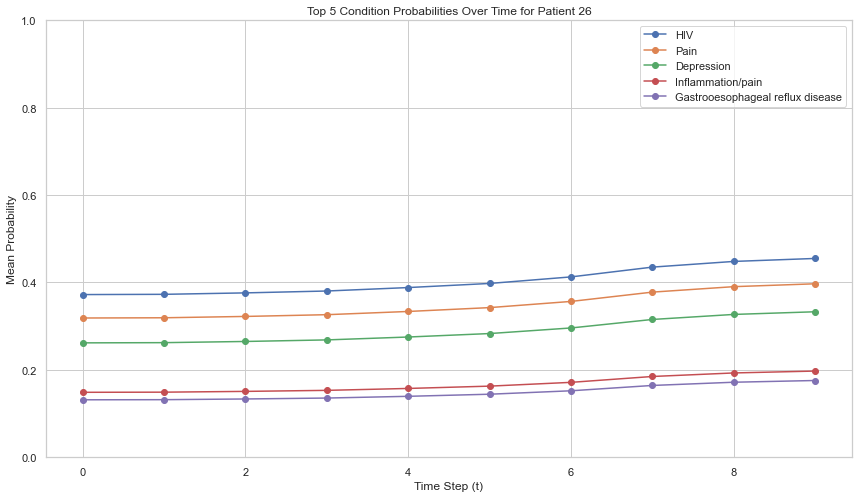

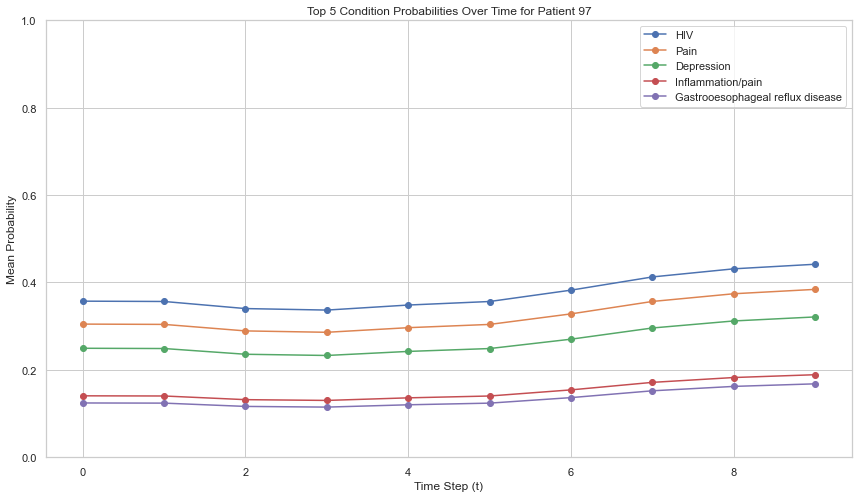

In [6]:
# Plot top condition probabilities over time for a few random patients
if prob_mean_t.size > 0:
    I, C, T = prob_mean_t.shape[1], prob_mean_t.shape[2], prob_mean_t.shape[0]
    
    # Select 3 random patients
    num_patients_to_plot = 3
    patient_indices = np.random.choice(I, size=num_patients_to_plot, replace=False)
    
    # For each patient, find top 5 conditions based on mean probability over time
    for pat_idx in patient_indices:
        # Mean probability across all time points for this patient
        mean_probs_pat = prob_mean_t[:, pat_idx, :].mean(axis=0)
        top_cond_indices = np.argsort(-mean_probs_pat)[:5]
        
        plt.figure(figsize=(12, 7))
        for cond_idx in top_cond_indices:
            # Get probability trajectory for this patient and condition
            prob_trajectory = prob_mean_t[:, pat_idx, cond_idx]
            plt.plot(range(T), prob_trajectory, marker='o', linestyle='-', label=f'{condition_names[cond_idx]}')
            
        plt.title(f'Top 5 Condition Probabilities Over Time for Patient {pat_idx}')
        plt.xlabel('Time Step (t)')
        plt.ylabel('Mean Probability')
        plt.ylim(0, 1)
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f'bym_ou_prob_trajectory_patient_{pat_idx}.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
else:
    print("Skipping trajectory plot as no probability data is available.")



### 2. Analysis of Lambda Change Through Time

This section focuses on how the latent `Lambda` values, which determine the probabilities, change over time. We will visualize the distribution of `Lambda` for top conditions and track their evolution.


Top 5 conditions at t=0: ['HIV', 'Pain', 'Depression', 'Inflammation/pain', 'Gastrooesophageal reflux disease']


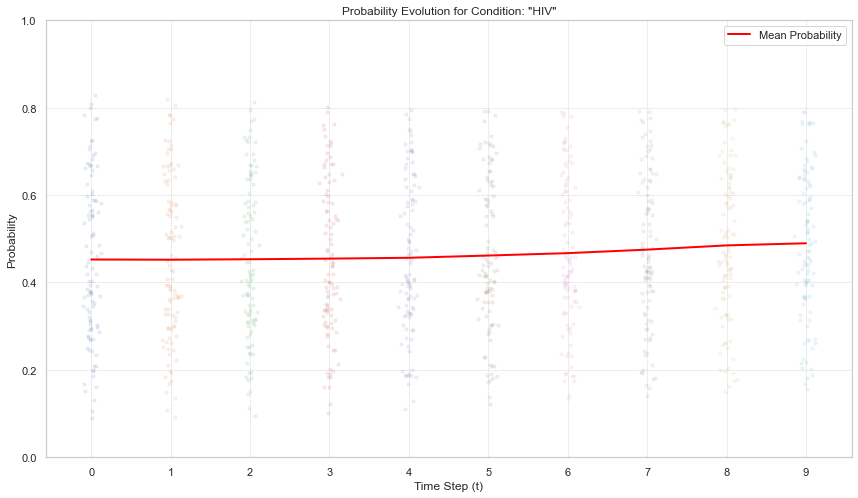

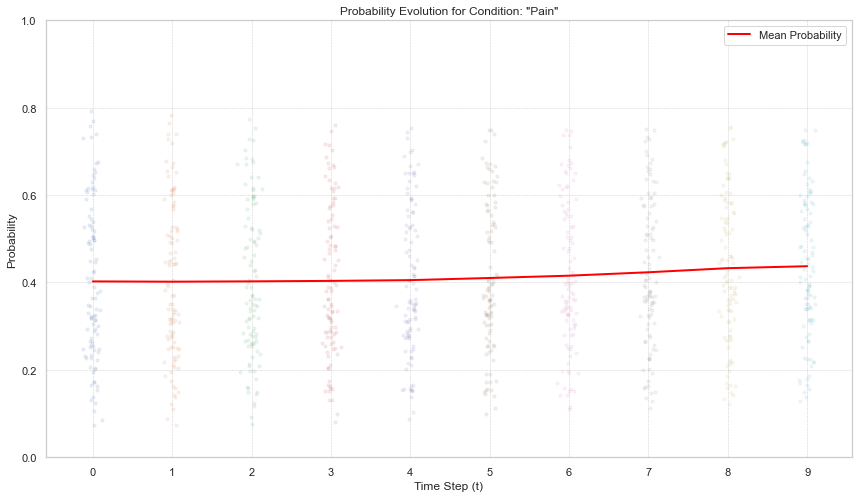

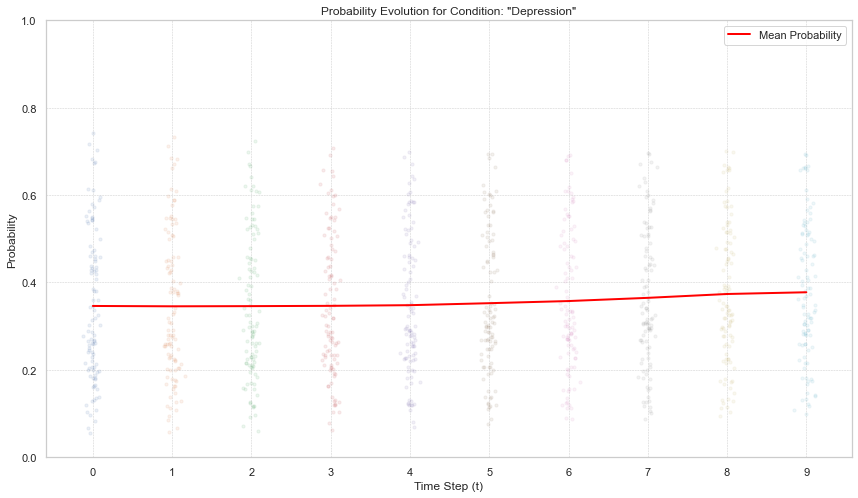

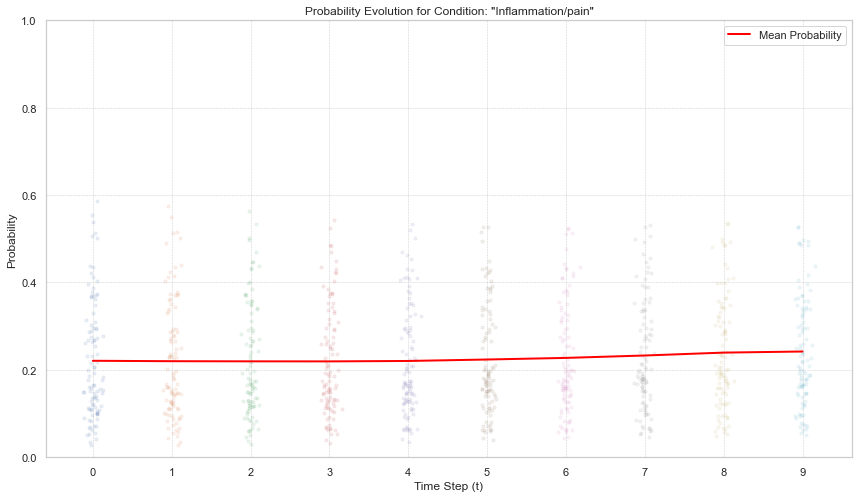

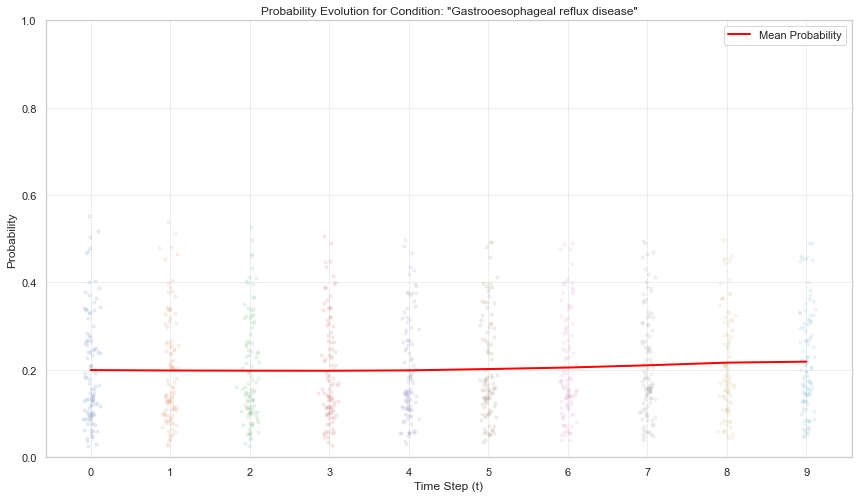

In [ ]:
# For the top 5 conditions by probability at t=0, create a scatterplot of their evolution over time for all patients.
if prob_mean_t.size > 0:
    T, I, C = prob_mean_t.shape
    
    # Find top 5 conditions based on mean probability at t=0
    mean_probs_t0 = prob_mean_t[0, :, :].mean(axis=0)
    top_5_cond_indices = np.argsort(-mean_probs_t0)[:5]
    
    print(f"Top 5 conditions at t=0: {[condition_names[i] for i in top_5_cond_indices]}")
    
    # Create a scatterplot for each of the top conditions
    for cond_idx in top_5_cond_indices:
        plt.figure(figsize=(12, 7))
        
        # Gather all probabilities for this condition across all patients and time points
        # prob_cond_t has shape (T, I)
        prob_cond_t = prob_mean_t[:, :, cond_idx]
        
        # Create x and y values for the scatter plot
        time_steps = np.arange(T)
        
        for t in time_steps:
            # Add a small jitter to time for better visualization
            t_jitter = t + np.random.normal(0, 0.05, size=I)
            plt.scatter(t_jitter, prob_cond_t[t, :], alpha=0.1, s=10)

        # Overlay the mean trajectory
        mean_trajectory = prob_cond_t.mean(axis=1)
        plt.plot(time_steps, mean_trajectory, color='red', linestyle='-', linewidth=2, label='Mean Probability')
            
        plt.title(f'Probability Evolution for Condition: "{condition_names[cond_idx]}"')
        plt.xlabel('Time Step (t)')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.xticks(time_steps)
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        
        # Sanitize condition name for filename
        import re as _re
        safe_cond_name = _re.sub(r"[^A-Za-z0-9._-]+", "_", condition_names[cond_idx])
        plt.savefig(os.path.join(PLOTS_DIR, f'bym_ou_prob_scatter_evolution_{safe_cond_name}.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
else:
    print("Skipping scatter plot of probability evolution as no probability data is available.")

